# AI Literacy 
## Time Series Analysis on Drug Overdose Death Rates with XML
### Author: Olivia Rueschhoff

The purpose of this project is to show my AI literacy. I chose to use chatGPT to help with this as it is one of the most common generative AI bots that is publicly available.

The data used in this project is nationally available "Drug overdose death rates, by drug type, sex, age, race, and Hispanic origin: United States" by the U.S. Department of Health & Human Services. 
The dataset used for this project is an **xml** file to demonstrait my understanding of parsing through an xml file as well as my ability to assist AI in going through it. 

**Any code in this file is generated from chatGPT unless otherwise specified.**

#### To separate my comments from ChatGPT's I will be using a triple hashmark ### on my comments and a single # on ChatGPT's

### How ChatGPT found the layout

response
 
 └── row
 
      └── row   <-- each of these is one observation
      
           ├── indicator
           
           ├── panel
           
           ├── year
           
           ├── age
           
           └── estimate   <-- THIS is your time series value
           
I then looked through the xml file and checked its accuaracy and nesting logic and it was correct. I found that each row/row/ held a row ID to act as the primary key for this dataset.

In [7]:
# Parsing the XML
import xml.etree.ElementTree as ET
import pandas as pd

# Load XML
### Had to Change path as AI didn't know exact path and name even from upload
tree = ET.parse("Data/Drug Overdose Death Rate Data.xml")
root = tree.getroot()

# Store extracted data
rows = []

# Each observation lives inside nested row tags
for record in root.findall(".//row/row"):

    rows.append({
        "indicator": record.findtext("indicator"),
        "panel": record.findtext("panel"),
        "year": record.findtext("year"),
        "age": record.findtext("age"),
        "estimate": record.findtext("estimate")
    })

# Convert to DataFrame
df = pd.DataFrame(rows)
df.head()

,indicator,panel,year,age,estimate
0,Drug overdose death rates,All drug overdose deaths,1999,All ages,6.1
1,Drug overdose death rates,All drug overdose deaths,2000,All ages,6.2
2,Drug overdose death rates,All drug overdose deaths,2001,All ages,6.8
3,Drug overdose death rates,All drug overdose deaths,2002,All ages,8.2
4,Drug overdose death rates,All drug overdose deaths,2003,All ages,8.9


In [17]:
### Clean the data to convert from Strings as xml is all Strings
# Convert types
df["year"] = pd.to_numeric(df["year"])
df["estimate"] = pd.to_numeric(df["estimate"])

# Sort chronologically
df = df.sort_values("year")

df.head()

,indicator,panel,year,age,estimate
1879,Drug overdose death rates,Drug overdose deaths involving any opioid,1999,45-54 years,2.7
1784,Drug overdose death rates,Drug overdose deaths involving any opioid,1999,85 years and over,NaN
420,Drug overdose death rates,All drug overdose deaths,1999,All ages,6.0
4066,Drug overdose death rates,Drug overdose deaths involving other synthetic...,1999,All ages,NaN
4372,Drug overdose death rates,Drug overdose deaths involving other synthetic...,1999,All ages,0.3


In [44]:
### Filtering Down Categories For each row to be less broad and more consistent with all points
df_filtered = df[
    (df["age"] == "All ages") &
    (df["panel"] == "All drug overdose deaths")
]
### Manually went in to drop null values as ChatGPT didn't think to check
df_clean = df_filtered.dropna(subset=["year", "estimate"])

In [39]:
### Making a correlation Heatmap to see the strength of the correlation between variables
numeric_df = df_clean.select_dtypes(include=["number"])
corr_matrix = numeric_df.corr()
print(corr_matrix)

              year  estimate
year      1.000000  0.516863
estimate  0.516863  1.000000


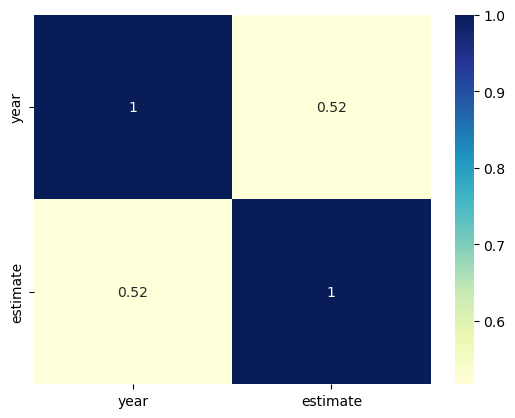

In [40]:
### ChatGPT originally did this in matplotlib 
### but Seaborn is much better and puts numerical values in the plot so I changed it to that
import seaborn as sb
sb.heatmap(corr_matrix, annot=True, cmap='YlGnBu')

plt.show()

In [41]:
### Run Pearson Correlation to check p-value significance
from scipy.stats import pearsonr

r, p_value = pearsonr(numeric_df["year"], numeric_df["estimate"])

print("Pearson Correlation Coefficient:", r)
print("P-value:", p_value)

Pearson Correlation Coefficient: 0.5168632339709975
P-value: 2.6931735857294327e-35


### Correlation Results
We have found a very statistically significant mediumly strong correlation between the year and the estimated amount of Drug Overdose deaths with about 52% being exaplainable by the year.

<Axes: title={'center': 'Drug Overdose Death Rate'}, xlabel='year'>

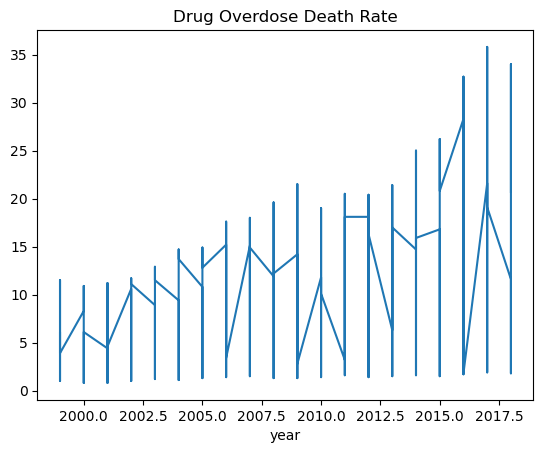

In [47]:
### Set up the data to align for a Time series
df_ts = df_clean.set_index("year")["estimate"]

df_ts.plot(title="Drug Overdose Death Rate")

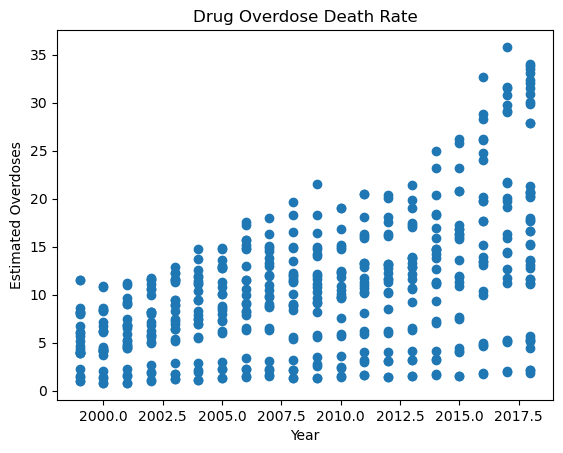

In [48]:
### ChatGPT originally plotted as a line graph, I changed to scatter plot to visualize better
import matplotlib.pyplot as plt

df_ts = df_clean.set_index("year")["estimate"]

plt.scatter(df_ts.index, df_ts.values)
plt.title("Drug Overdose Death Rate")
plt.xlabel("Year")
plt.ylabel("Estimated Overdoses")
plt.show()

In [57]:
### Run Dickey-Fuller Test to test for Stationarity
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_ts)

print("ADF Statistic:", adf_result[0])
print("P-value:", adf_result[1])

ADF Statistic: -1.4066138553163177
P-value: 0.5791012779195038


## Stationarity Result
The p-value is significantly larger than 0.05 indicating our dataset is definately not stationary. This suggests that the ARIMA model may not be a good model to fit our data. But we will proceed to try dropping the differences to see if that makes it stationary. 

In [58]:
df_diff = df_ts.diff().dropna()

adf_result = adfuller(df_diff)

print("ADF Statistic:", adf_result[0])
print("P-value:", adf_result[1])

ADF Statistic: -11.115432227340666
P-value: 3.5730129968373215e-20


## Stationary Results 2
The p-value for the differences is < 0.05 indicating we are now working with a stationary dataset and thus the ARIMA model can be used. And our differencing order is 1. 

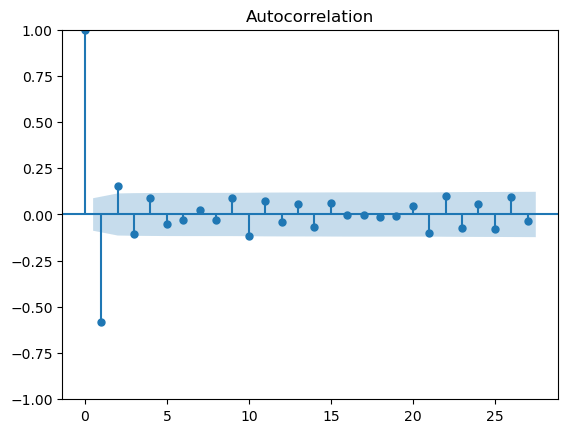

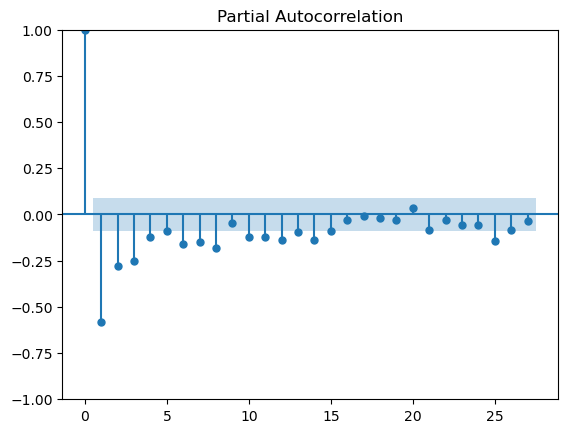

In [55]:
# Identify ARIMA Parameters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_diff)
plt.show()

plot_pacf(df_diff)
plt.show()

In [70]:
from statsmodels.tsa.arima.model import ARIMA

### I added in the parameters for the model
### d is 1 because thats how much differencing was done to get stationary
### p is 1 or 2 will be checked and compared (Autoregressive Order)
### q is 1 because the spike at lag 2 jumps above the confidence interval (shaded region) indication it is statistically significant
### q is the moving average order
d = 1 
p = 1
q = 1
model = ARIMA(df_ts, order=(p,d,q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               estimate   No. Observations:                  497
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1610.233
Date:                Tue, 03 Feb 2026   AIC                           3226.466
Time:                        13:09:12   BIC                           3239.085
Sample:                             0   HQIC                          3231.419
                                - 497                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0661      0.039     -1.711      0.087      -0.142       0.010
ma.L1         -0.9555      0.011    -88.669      0.000      -0.977      -0.934
sigma2        38.4676      2.268     16.964      0.0

C:\Users\ruesc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\ruesc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\ruesc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [72]:
### Checking ARIMA(2,1,1) to compare which is better
d = 1 
p = 2
q = 1
model = ARIMA(df_ts, order=(p,d,q))
model_fit = model.fit()

print(model_fit.summary())

C:\Users\ruesc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\ruesc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\ruesc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               estimate   No. Observations:                  497
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1607.238
Date:                Tue, 03 Feb 2026   AIC                           3222.476
Time:                        13:09:16   BIC                           3239.302
Sample:                             0   HQIC                          3229.081
                                - 497                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0535      0.039     -1.370      0.171      -0.130       0.023
ar.L2          0.1130      0.034      3.344      0.001       0.047       0.179
ma.L1         -0.9610      0.011    -90.424      0.0

## Model Comparison 

Between the two candidate models, ARIMA(2,1,1) achieves a lower AIC and a higher log‑likelihood, while ARIMA(1,1,1) achieves a slightly lower BIC. Overall, the criteria leans toward ARIMA(2,1,1).

For ARIMA(1,1,1), the autoregressive term is weakly negative and not statistically significant (p = 0.087), while the moving‑average term is highly significant (p < 0.001), consistent with the strong MA behavior suggested by the ACF plot. Diagnostic tests show that residuals are approximately independent (Ljung–Box) and roughly normally distributed (Jarque–Bera). However, heteroskedasticity is present, indicating non‑constant variance over time—interesting, but not fatal for model validity.

For ARIMA(2,1,1), the first autoregressive term is not significant, but the second autoregressive term is strongly significant (p = 0.001), and the moving‑average term remains highly significant (p < 0.001). Residual diagnostics mirror those of the simpler model: independence and approximate normality hold, while heteroskedasticity persists.

Taken together, the stronger likelihood fit and more informative autoregressive structure suggest that ARIMA(2,1,1) provides the better overall model for forecasting this series.

AI suggested standard ARIMA structures, but human interpretation was required to evaluate the statistical significances, residual independence, and heteroskedasticity patterns.

In [74]:
forecast = model_fit.forecast(steps=5)
print(forecast)

497    16.154050
498    18.533843
499    17.892556
500    18.195897
501    18.107165
Name: predicted_mean, dtype: float64


C:\Users\ruesc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## Trying a Different Model Type
With my knowledge of regression models I would like to try a different model due to both ARIMA models having heteroskedasticity present. This suggests using either an ARCH or GARCH model. GARCH follows the ARCH model but includes previous variance models and as this is a time series model it's likely to rely on past years so both ARCH and GARCH will be modeled. 

In [77]:
# Since ARIMA modeled the mean, we will use it's residuals for ARCH/GARCH
residuals = model_fit.resid

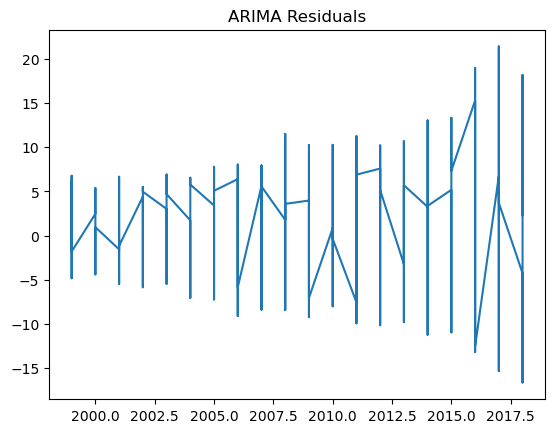

In [78]:
# Plot residuals
plt.figure()
plt.plot(residuals)
plt.title("ARIMA Residuals")
plt.show()

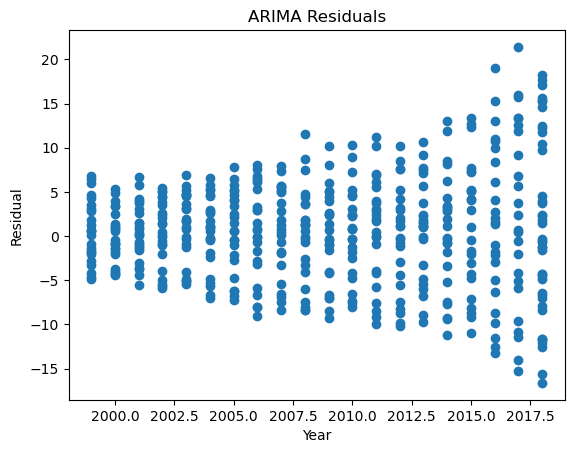

In [79]:
### Plot into a skatter plot to better visualize
plt.scatter(df_ts.index, residuals)
plt.title("ARIMA Residuals")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

## Residual Plot Interpretation
The cone shape structure of the residuals plot shows the clustering volitality, ie visually confirming heteroskedasticity and thus justifying the use of the ARCH and GARCH models.

In [80]:
# Fit the ARCH model
from arch import arch_model

arch_model_fit = arch_model(residuals, vol="ARCH", p=1)
arch_results = arch_model_fit.fit()

print(arch_results.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1618.9567322935973
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1724.7663835347546
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1599.9232233221421
Iteration:      4,   Func. Count:     21,   Neg. LLF: 1599.921035254386
Iteration:      5,   Func. Count:     25,   Neg. LLF: 1599.918201404926
Iteration:      6,   Func. Count:     29,   Neg. LLF: 1599.917762652422
Iteration:      7,   Func. Count:     33,   Neg. LLF: 1599.9177218827454
Iteration:      8,   Func. Count:     36,   Neg. LLF: 1599.9177218825448
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1599.9177218827454
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 8
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-square

In [81]:
# Fit standard GARCH model
garch_model_fit = arch_model(residuals, vol="GARCH", p=1, q=1)
garch_results = garch_model_fit.fit()

print(garch_results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2214.6251314439987
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1865.3763423105563
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1548.934214090007
Iteration:      4,   Func. Count:     23,   Neg. LLF: 2551.5215838617423
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1648.9485888701095
Iteration:      6,   Func. Count:     37,   Neg. LLF: 1545.9622532753801
Iteration:      7,   Func. Count:     42,   Neg. LLF: 1546.0119326795816
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1545.9220141825397
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1545.9194309702737
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1545.918852555357
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1545.9188516389845
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1545.9188516389845
            Iterations: 11
            Function evaluations: 63
            Gradient evalu

## ARCH VS GARCH Comparison
The GARCH model provided a substantially better fit to the Drug Overdose Death Rate data than the ARCH model. This is made evident by its notably lower AIC (3099.84 vs. 3205.84) and higher log-likelihood. While the ARCH model captured short-term volatility effects, the GARCH model incorporated both recent shocks and past volatility, allowing it to more accurately represent persistent variance patterns observed in the residuals. The GARCH results indicated extremely strong volatility persistence, with the combined α and β parameters approaching one, suggesting that periods of increased variability tend to propagate over time. Additionally, the conditional volatility estimates from the GARCH model aligned more closely with the observed increasing fluctuation in overdose death rates, making it a more appropriate and informative model for this dataset.

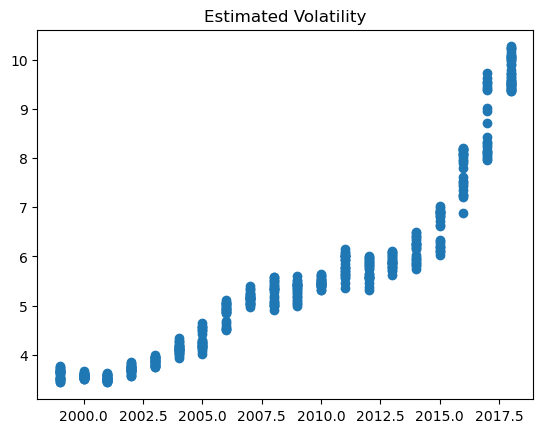

In [84]:
# Plot Conditional Volatility
plt.figure()
plt.scatter(df_ts.index, garch_results.conditional_volatility)
plt.title("Estimated Volatility")
plt.show()

## Conditional Voltality Meaning
This graphs nearly exponential increase over the time span indicates a few things including an increasing uncertainty in overdose trends, an escalating epidemic instability in overdoses, and structural change in public health dynamics. All of which are things that are known to be true within the United States, verifying our data. 


C:\Users\ruesc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ruesc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


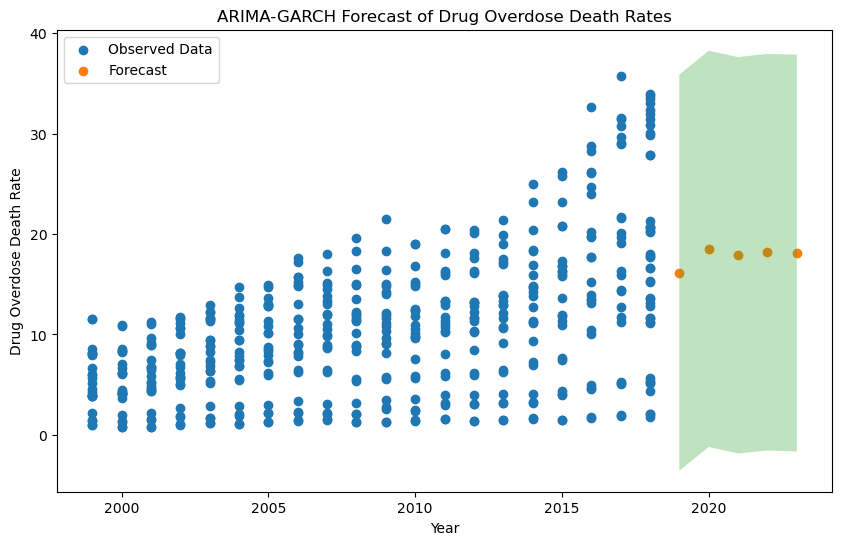

In [93]:
# ----- Forecast Horizon -----
### Forecast next 5 years
steps = 5

# ----- ARIMA Mean Forecast -----
mean_forecast = model_fit.forecast(steps=steps)

# ----- GARCH Variance Forecast -----
garch_forecast = garch_results.forecast(horizon=steps)
forecast_variance = garch_forecast.variance.values[-1]

forecast_volatility = np.sqrt(forecast_variance)

# ----- Create Future Year Index -----
last_year = df_ts.index[-1]
future_years = np.arange(last_year + 1, last_year + steps + 1)

# Convert forecasts to Series with proper index
mean_forecast = pd.Series(mean_forecast.values, index=future_years)
volatility_series = pd.Series(forecast_volatility, index=future_years)

# ----- Confidence Intervals -----
upper_bound = mean_forecast + 1.96 * volatility_series
lower_bound = mean_forecast - 1.96 * volatility_series

# ----- Plot -----
plt.figure(figsize=(10,6))

# Historical data
plt.scatter(df_ts.index, df_ts.values, label="Observed Data")

# Forecast
plt.scatter(mean_forecast.index, mean_forecast.values, label="Forecast")

# Confidence Interval
plt.fill_between(
    future_years,
    lower_bound,
    upper_bound,
    alpha=0.3
)

# Labels
plt.xlabel("Year")
plt.ylabel("Drug Overdose Death Rate")
plt.title("ARIMA-GARCH Forecast of Drug Overdose Death Rates")

plt.legend()
plt.show()
